# Creating Catalogs in opticam_new

`opticam_new` compiles images for each filter to create source catalogs. To do this, it aligns and stacks the images for each filter before subtracting the background and using image segmentation to identify sources. Let's see it in action using the test data generated by the `create_test_data.py` script. First, we need to instance a `Reducer` object:

In [3]:
from opticam_new import Reducer

name = "Test"
date = "20240101"

reducer = Reducer(
    data_directory=f"/mnt/SATA1/Data/Opticam/Raw/{name}/{date}/",
    out_directory=f"/home/zac/Documents/University/PhD/Opticam_new/Reduced/{name}/{date}/",
    show_plots=True
)

[OPTICAM] Scanning files ...


100%|██████████| 3000/3000 [00:00<00:00, 7399.83it/s]

[OPTICAM] Done.
[OPTICAM] Binning: ['8x8']
[OPTICAM] Read transforms from file.
[OPTICAM] Read g-band catalog from file.
[OPTICAM] Read i-band catalog from file.
[OPTICAM] Read r-band catalog from file.


Now we can initialise our catalogs:

[OPTICAM] Initialising catalogs ...
[OPTICAM] Aligning and stacking g-band images in batches ...


100%|██████████| 16/16 [00:01<00:00,  8.08it/s]


[OPTICAM] Done. 0 image(s) could not be aligned.
[OPTICAM] Aligning and stacking i-band images in batches ...


100%|██████████| 16/16 [00:01<00:00,  8.47it/s]


[OPTICAM] Done. 0 image(s) could not be aligned.
[OPTICAM] Aligning and stacking r-band images in batches ...


100%|██████████| 16/16 [00:01<00:00,  8.16it/s]


[OPTICAM] Done. 0 image(s) could not be aligned.


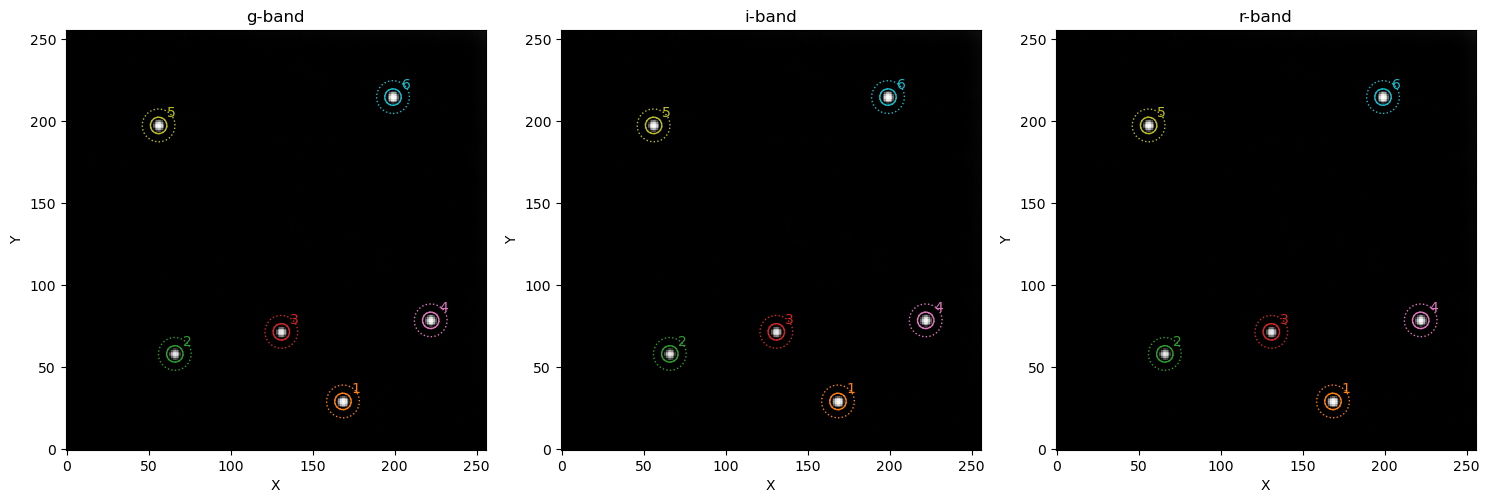

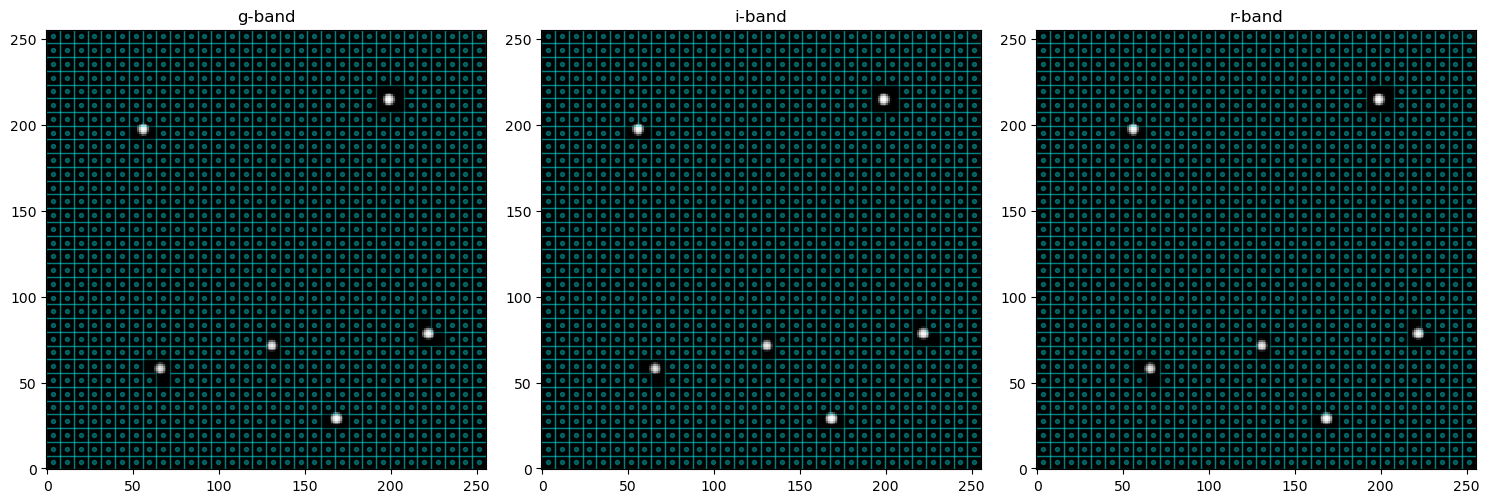

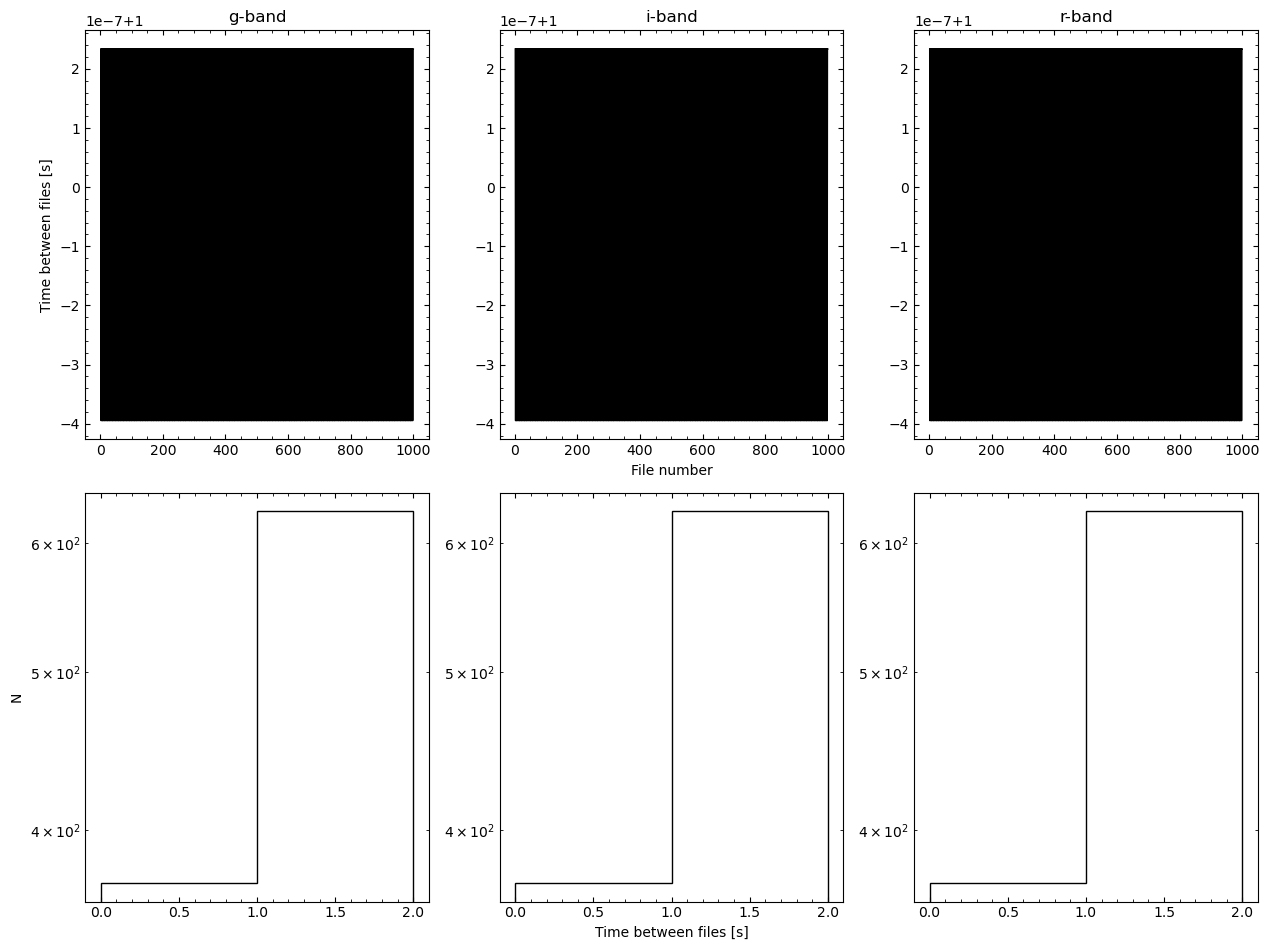

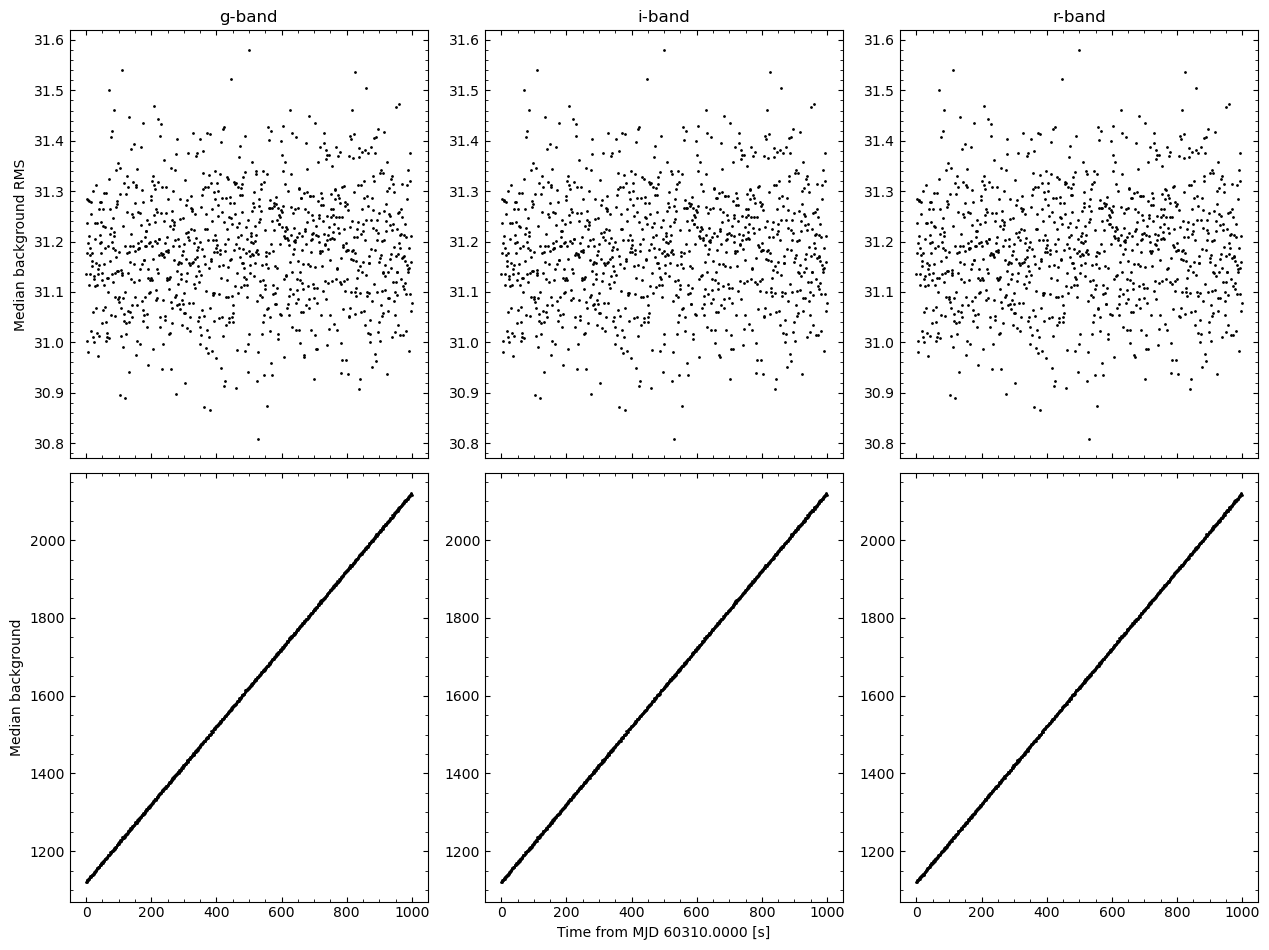

In [4]:
reducer.initialise_catalogs()

The `initialise_catalogs()` method produces four plots, all of which are saved to `out_directory`. From top to bottom, these plots are:
- The source catalogs (saved to `out_directory/cat/catalogs.png`).
- The background meshes (saved to `out_directory/diag/background_meshes.png`).
- The time between observations (saved to `out_directory/diag/header_times.png`).
- The average background as a function of time (saved to `out_directory/diag/background.png`).

The source catalogs plot is pretty self-explanatory: it shows the detected sources for each filter, giving each source a numbered label, and shows the aperture and annulus size that will be used to perform forced photometry.

The background meshes are provided for sanity checking. `photutils`, that package that handles the background calculations in `opticam_new`, recommends ensuring that the image is covered by an integer number of boxes in both dimensions, and that individual boxes are larger than the typical size of sources in the image.

The time between observations is self-explanatory. This is included as a sanity check to check whether it's worth reducing the data at all. For example, if the user is looking for a rotation period, but the time between observations is greater than this period, then it's pointless reducing the data in that case.

The average background as a function of time is also self-explanatory. This is also included as a sanity check. If there is a lot of structure in the background, then this can bleed into the light curves and be confused for intrinsic variability.

Now that we've seen what `initialise_catalogs()` does, let's talk about how it works. Images are aligned per filter relative to the first (i.e., earliest) image using `astroalign`. In general, this works quite well, but it's not perfect. Unfortunately, OPTICam data do not come with WCS (world coordinate system) information, and so translating from pixel coordinates to RA and DEC would require astrometric source matching, which is an in-development feature. In future, it will be possible to use astrometry to align all the images for all filters, producing a single catalog. Until then, we have to use `astroalign`, which cannot account for the differences in field-of-view or pixel-scale between the three cameras.

As the images are aligned, they are also stacked. Stacking improves the signal-to-noise ratio of sources (provided the alignments are good), increasing the number of sources that can be detected. To speed up the alignment and stacking process, it can be parallelised. To avoid holding too many images in memory simultaneously, images are aligned and stacked in batches in parallel. The number of parallel processes is determined by the `number_of_processors` parameter of `opticam_new.Reducer()`. It's best not to set this value to the maximum number of available processors since there is some overhead incurred from parallel processing. By default, `number_of_processors` will be set to half the number of available processors. Moreover, for the best performance, `initialise_catalogs()`'s `batch_size` parameter should be set such that there are at least as many batches as parallel processes. By default, `opticam_new` will determine a suitable value for `batch_size` based on the number of images given and the number of processors available.

Once the images have been alignd and stacked, the background is then subtracted and sources are identified. When sources are detected, they are described using a 2D Gaussian. Each source therefore has a centroid, a semimajor and semiminor sigma, and an orientation (if the source is not circular). The distribution of semimajor sigmas is used to determine the aperture size depending on the function given to `opticam_new.Reducer()`'s `aperture_selector` parameter. By default, `opticam_new` will choose the median semimajor sigma, and scale this by a factor of 5 to determine the aperture size. However, any function that takes an list of floating point values and returns a single floating point value can be passed (e.g., `numpy.max` or `numpy.min`). The scaling of this value is then determined by the value of `scale` passed to `opticam_new.Reducer()`. Similarly, the size of the annulus is controlled by the `r_in_scale` and `r_out_scale` parameters passed to `opticam_new.Reducer()`. Note: `r_in_scale` and `r_out_scale` are defined relative to the aperture size, so `r_in_scale=1` and `r_out_scale=2` (the default values) will produce an annulus whose inner radius is identical to the aperture radius, while the outer radius is twice the aperture radius.